# Machine Learning - Project 1

In [178]:
# Setup and imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import proj1_helpers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Implementations of ML Methods

### Test data:

Testing data for helper functions

In [179]:
y = np.array([1, 2, 3, 4])
tx = np.array([[1, 2, 3], 
               [4, 5, 6], 
               [7, 8, 9], 
               [10, 11, 12]])
w = np.array([0, 0, 0])

### Helper functions:

In [180]:
def compute_loss_mse(y, tx, w):
    """Calculate the MSE loss."""
    N = len(y)
    e = y - np.dot(tx, w)
    return np.dot(e,e) / (2 * N)

In [181]:
def compute_loss_mae(y, tx, w):
    """Calculate the MAE loss."""
    N = len(y)
    e = y - np.dot(tx, w)
    return np.sum(np.absolute(e)) / N

In [182]:
def compute_rmse(y, tx, w):
    """Computes the Root Mean Square Error"""
    mse = compute_loss_mse(y, tx, w)
    return np.sqrt(2 * mse)

In [183]:
"""Filippas"""
def rmse_calc(mse):
    rmse = np.sqrt(mse*2)
    return rmse

In [184]:
def compute_gradient_mse(y, tx, w):
    """Compute the MSE gradient."""
    N = len(y)
    e = y - np.dot(tx, w)
    return (-1/N) * np.dot(np.transpose(tx), e)

In [185]:
def compute_stochastic_subgradient_mae(y, tx, w):
    """Compute a stochastic subgradient from just few examples n and their corresponding y_n labels."""
    N = len(y)
    e = y - np.dot(tx, w)
    abs_e_subgrad = [np.sign(en) for en in e] # Sign chosen for subgradient of absolute value function
    return (-1/N) * np.dot(np.transpose(tx), abs_e_subgrad)

In [186]:
def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    """
    Generate a minibatch iterator for a dataset.
    Takes as input two iterables (here the output desired values 'y' and the input data 'tx')
    Outputs an iterator which gives mini-batches of `batch_size` matching elements from `y` and `tx`.
    Data can be randomly shuffled to avoid ordering in the original data messing with the randomness of the minibatches.
    Example of use :
    for minibatch_y, minibatch_tx in batch_iter(y, tx, 32):
        <DO-SOMETHING>
    """
    data_size = len(y)

    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_y = y[shuffle_indices]
        shuffled_tx = tx[shuffle_indices]
    else:
        shuffled_y = y
        shuffled_tx = tx
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]

In [187]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    np.random.seed(seed) # set seed
    permuted_idxs = np.random.permutation(x.shape[0])
    train_size = int(ratio * x.shape[0])
    train_idxs, test_idxs = permuted_idxs[:train_size], permuted_idxs[train_size:]
    
    return x[train_idxs], x[test_idxs], y[train_idxs], y[test_idxs]

### Functions to implement for project 1 submission:

In [188]:
"""Linear regression using gradient descent"""
def least_squares_GD(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm using MSE."""
    w = initial_w
    for n_iter in range(max_iters):
        grad = compute_gradient_mse(y, tx, w)
        loss = compute_loss_mse(y, tx, w)
        w = w - gamma * grad
        
    rmse = compute_rmse(y, tx, w)

    return w, rmse

In [189]:
"""Linear regression using stochastic gradient descent"""
def stochastic_subgradient_descent_mae(y, tx, initial_w, max_iters, gamma):
    """Stochastic subgradient descent algorithm using MAE."""
    batch_size = 1
    w = initial_w
    for n_iter in range(max_iters):
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size):
            g = compute_stochastic_subgradient_mae(minibatch_y, minibatch_tx, w)
            w = w - gamma * g
        loss = compute_loss_mae(y, tx, w)
        print("Stochastic Subgradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return w, loss

In [190]:
def least_squares(y, tx):
    """Calculates the explicit least squares solution.
    Returns rmse, optimal weights"""
    N = tx.shape[0]
    D = tx.shape[1]
    rank_tx = np.linalg.matrix_rank(tx)
    
    # Check if tx is invertible. If so, find explicit solution
    # using real inverses.
    # If not, find explicit solution using pseudoinverses.
    if (rank_tx == max(tx.shape[0], tx.shape[1])):
        gramian_inv = np.linalg.inv(np.dot(tx.T, tx))
        w = np.dot(gramian_inv, np.dot(tx.T, y))
    else:
        U, s, V_T = np.linalg.svd(tx)
        S_inv_T = np.zeros((D, N))
        S_inv_T[:len(s), :len(s)] = np.diag(1/s)
        w = np.dot(V_T.T, np.dot(S_inv_T, np.dot(U.T, y)))
    
    rmse = compute_rmse(y, tx, w)
    
    return w, rmse

In [191]:
"""Filippas"""
def least_squares_2(y, tx):
    """calculate the least squares solution."""
    N = tx.shape[0]
    w = np.linalg.solve(np.dot(tx.T, tx), np.dot(tx.T, y))
    
    e = y-np.dot(tx, w)
    mse = (e ** 2).mean()
    return w, mse

In [192]:
def ridge_regression(y, tx, lambda_):
    """Ridge regression using normal equations"""
    
    #if (lambda_ == 0):
    #    return least_squares(y, tx)
    
    N = tx.shape[0]
    D = tx.shape[1]
    
    inv = np.linalg.inv(np.dot(tx.T, tx) + 2 * N * lambda_ * np.identity(D))
    w = np.dot(inv, np.dot(tx.T, y))
    
    rmse = compute_rmse(y, tx, w)

    return w, rmse

In [212]:
 def ridge_regression2(y, tx, lambda_):
    """implement ridge regression."""
    N = tx.shape[0]
    D = tx.shape[1]
    inver = np.linalg.inv(np.dot(tx.T, tx) + (2 * N * lambda_ * np.identity(D)))
    w = np.dot(inver, np.dot(tx.T,y))
    mse = compute_loss_mse(y, tx, w)
    rmse = rmse_calc(mse)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # ridge regression: TODO
    # ***************************************************
    return w, rmse

In [213]:
"""Logistic regression using gradient descent or SGD"""
def logistic_regression(y, tx, initial_w, max_iters, gamma):
    raise NotImplementedError

In [214]:
"""Regularized logistic regression using gradient descent or SGD"""
def reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma):
    raise NotImplementedError

## Higgs Data Analysis

### Experimental functions

All of these functions can be used experimentally to, in one way or the other, improve the predictions.

In [215]:
def correctness(yb, y_pred):
    """Takes inputs known y and predicted y and prints the ratio of correct predictions vs incorrect ones."""
    correct = 0
    for i in range(len(y_pred)):
        if (y_pred[i] == yb[i]):
            correct += 1
        
    incorrect = len(y_pred) - correct
    perc = correct / len(y_pred) * 100
    print("Total correct:", correct, "\nTotal incorrect:", incorrect, "\nCorrect percentage:", perc, "%")

In [216]:
def replace_nan_by_mean(tx, nan_value):
    """Replaces values with a specified nan_value by the column mean."""
    tx[tx == nan_value] = np.nan
    col_mean = np.nanmean(tx, axis=0)
    return np.where(np.isnan(tx), col_mean, tx)

In [217]:
def replace_nan_by_median(tx, nan_value):
    """Replaces values with a specified nan_value by the column median."""
    tx[tx == nan_value] = np.nan
    col_median = np.nanmedian(tx, axis=0)
    return np.where(np.isnan(tx), col_median, tx)

In [218]:
def drop_nan_rows(tx, nan_value):
    """Drop all rows that contain a nan equaling the specified nan_value."""
    tx[tx == nan_value] = np.nan
    return tx[~np.isnan(tx).any(axis=1)]

In [219]:
def build_simple_poly(tx, degree):
    """
    Builds simple polynomial basis function for input data matrix tx, for j=0 up to j=degree,
    where the result will be a matrix of form [1, tx, tx^2, ..., tx^j].
    tx^j denotes that for each x_i,k in tx, the result will be (x_i,k)^j
    """
    poly = np.ones((tx.shape[0], 1))

    for j in range(1, degree+1):
        poly = np.column_stack((poly, np.power(tx, j)))

    return poly

In [220]:
import itertools

# TODO: Optimize. Very slow!
def build_mult_comb(tx, deg, cols=[]):
    """
    Returns all multiplicative combinations of the specified columns for degree deg.
    For len(col) = D', there are (D' choose deg) combinations of columns that get
    returned as a matrix.
    If cols is not given, it returns the combinations of all columns of tx.
    """
    N = tx.shape[0]
    if (cols == []):
        comb_iter = itertools.combinations_with_replacement(range(tx.shape[1]), deg)
    else:
        comb_iter = itertools.combinations_with_replacement(cols, deg)
    mult = []
    for comb in comb_iter:
        mult_col = np.ones(N)
        for idx in comb:
            tx_col = tx[:,idx]
            mult_col = np.multiply(mult_col, tx_col)
        mult.append(mult_col.tolist())
    return np.array(mult).T

def build_advanced_poly(tx, degree, cols=[]):
    """
    Builds full polynomial basis function for input data matrix tx, for j=0 up to j=degree,
    where the result will be a matrix of form:
    [1, tx, comb_mult(tx, 2), ..., comb_mult(tx, j)]
    comb_mult(tx, 2) denotes all multiplicative combinations of the selected columns of tx.
    If cols is not given, it returns the combinations of all columns of tx.
    """
    poly = np.ones((tx.shape[0], 1))

    for j in range(1, degree+1):
        mult = build_mult_comb(tx, j, cols)
        poly = np.column_stack((poly, mult))

    return poly

# Testing on data

Import training data:

In [221]:
from proj1_helpers import *

data_path = "../data/train.csv"
yb, input_data, ids = load_csv_data(data_path, sub_sample=False)

Transform the data to more useable data, by replacing NaN's by the column mean and creating a polynomial base expansion.

By previous data analysis, important_cols are selected to be the few "most influencial" features. We use only those few weights in the polynomial base expansion for computational efficiency.

| Index | Feature                   |
|-------|---------------------------|
|  0    | DER_mass_MMC              |
| 1     | DER_mass_traverse_met_lep |
| 2     | DER_mass_vis              |
| 13    | PRI_tau_pt                |
| 11    | DER_met_phi_centrality    |
| 10    | DER_pt_ratio_lep_tau      |
| 7     | DER_deltar_tau_lep        |
| 19    | PRI_met                   |

In [222]:
input_data = replace_nan_by_median(input_data, -999)

important_cols = [0, 1, 2, 7, 10, 11, 13, 19]
degree = 2 # With current implementation, higher than 5 is comp. infeasable, but it gives the best results!

x_poly = build_advanced_poly(input_data, degree, important_cols)

x_train, x_test, y_train, y_test = split_data(x_poly, yb, ratio=0.9, seed=123456789)

lambda=0.000010000, Training RMSE=0.807, Testing RMSE=0.804
lambda=0.000022758, Training RMSE=0.807, Testing RMSE=0.804
lambda=0.000051795, Training RMSE=0.807, Testing RMSE=0.804
lambda=0.000117877, Training RMSE=0.807, Testing RMSE=0.805
lambda=0.000268270, Training RMSE=0.807, Testing RMSE=0.805
lambda=0.000610540, Training RMSE=0.808, Testing RMSE=0.807
lambda=0.001389495, Training RMSE=0.810, Testing RMSE=0.809
lambda=0.003162278, Training RMSE=0.812, Testing RMSE=0.811
lambda=0.007196857, Training RMSE=0.815, Testing RMSE=0.815
lambda=0.016378937, Training RMSE=0.819, Testing RMSE=0.819
lambda=0.037275937, Training RMSE=0.823, Testing RMSE=0.824
lambda=0.084834290, Training RMSE=0.827, Testing RMSE=0.828
lambda=0.193069773, Training RMSE=0.829, Testing RMSE=0.830
lambda=0.439397056, Training RMSE=0.831, Testing RMSE=0.832
lambda=1.000000000, Training RMSE=0.832, Testing RMSE=0.833


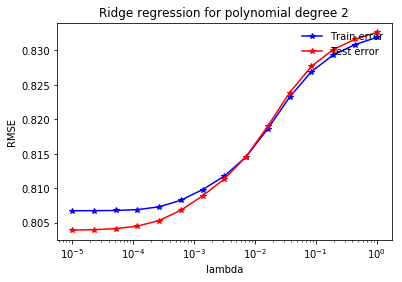

In [223]:
from plots import *

# Experiment to find best lambda
def ridge_regression_demo():
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        weights, rmse = ridge_regression(y_train, x_train, lambda_)
        rmse_tr.append(compute_rmse(y_train, x_train, weights))
        rmse_te.append(compute_rmse(y_test, x_test, weights))
        
        print("lambda={l:.9f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, 2)
    
ridge_regression_demo()

In [224]:
"""Help function"""
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [225]:
"""Help function"""
def split_cross_data(y, x, k_indices, k):
    k_test = k-1
    test_ind = k_indices[k_test]
    tr_ind = np.delete(k_indices, k_test, axis=0)
    tr_ind = np.array(tr_ind).flatten()
    x_te = x[test_ind]
    y_te = y[test_ind]
    x_tr = x[tr_ind]
    y_tr = y[tr_ind]
    return x_tr, y_tr, x_te, y_te

In [226]:
def build_poly(x, degree):
    poly_base = np.ones((x.shape[0], 1))
    for j in range(1, degree+1):
        poly_base = np.column_stack((poly_base, np.power(x, j)))
    poly_base = np.array(poly_base)
    return poly_base

In [227]:
"""Help function"""
import matplotlib.pyplot as plt

def cross_validation_visualization(lambds, mse_tr, mse_te):
    """visualization the curves of mse_tr and mse_te."""
    plt.semilogx(lambds, mse_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, mse_te, marker=".", color='r', label='test error')
    plt.xlabel("lambda")
    plt.ylabel("rmse")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    plt.savefig("cross_validation")

In [232]:
def cross_validation(y, x, k, lambda_, k_indices, degree):
    """return the loss of ridge regression."""
    loss_tr = []
    loss_te = []
    important_cols = [0, 1, 2, 7, 10, 11, 13, 19]
    degree = 2 # With current implementation, higher than 5 is comp. infeasable, but it gives the best results!
    for k in range(k):
        x_tr, y_tr, x_te, y_te = split_cross_data(y,x,k_indices,k)
        # ***************************************************
        # INSERT YOUR CODE HERE
        # get k'th subgroup in test, others in train: TODO
        # ***************************************************
        poly_tr = build_advanced_poly(x_tr, degree, important_cols)
        poly_te = build_advanced_poly(x_te, degree, important_cols)
        # ***************************************************
        # INSERT YOUR CODE HERE
        # form data with polynomial degree: TODO
        # ***************************************************
        w, tr_rmse = ridge_regression(y_tr, poly_tr, lambda_)
        
        # ***************************************************
        # INSERT YOUR CODE HERE
        # ridge regression: TODO
        # ***************************************************
        te_rmse = compute_rmse(y_te, poly_te, w)
        
        loss_tr.append(tr_rmse)
        loss_te.append(te_rmse)
        
    avg_tr = np.array(loss_tr).mean()
    avg_te = np.array(loss_te).mean()
    
        # ***************************************************
        # INSERT YOUR CODE HERE
        # calculate the loss for train and test data: TODO
        # ***************************************************
        
    return avg_tr, avg_te

In [233]:
seed = 1
degree = 7
k_fold = 4
lambdas = np.logspace(-4, 0, 30)
lambda_ = -3
k_indices = build_k_indices(y, k_fold, seed)
cross_validation(yb, x_poly, k_fold, lambda_, k_indices, degree)

(6.763661906786544e-07, 1.4182529342883738)

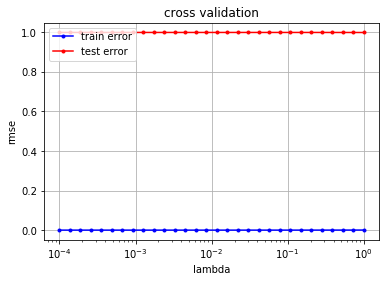

In [234]:
#from plots import cross_validation_visualization

def cross_validation_demo():
    seed = 1
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    lambda_ = 0.8
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    
    rmse_tr = []
    rmse_te = []
    
    for ind, lambda_ in enumerate(lambdas):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # ridge regression with a given lambda
        # ***************************************************
        loss_tr, loss_te = cross_validation(yb, input_data, k_fold, lambda_, k_indices, degree)
        
        rmse_tr.append(loss_tr)
        rmse_te.append(loss_te)
        
    # ***************************************************
    # INSERT YOUR CODE HERE
    # cross validation: TODO
    # ***************************************************    
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    
cross_validation_demo()

In [231]:
# Fill in best lambda from above and get weights
weights, rmse = ridge_regression(y_train, x_train, lambda_=0.00001)

In [177]:
# Predict labels with found weights and print some useful information about quality of fit
y_pred = predict_labels(weights, x_poly)
correctness(yb, y_pred)

print("-----------------------------")

rmse_train = compute_rmse(y_train, x_train, weights)
rmse_test = compute_rmse(y_test, x_test, weights)
print("Train RMSE:", rmse_train, ", Test RMSE:", rmse_test)

Total correct: 192475 
Total incorrect: 57525 
Correct percentage: 76.99000000000001 %
-----------------------------
Train RMSE: 0.806750582846 , Test RMSE: 0.80393570686


Load and transform test data:

In [32]:
test_path = "../data/test.csv"
yb_test, input_data_test, ids_test = load_csv_data(test_path, sub_sample=False)

In [33]:
input_data_test = replace_nan_by_median(input_data_test, -999)
x_submit_poly = build_advanced_poly(input_data_test, degree, important_cols)

In [34]:
y_test_pred = predict_labels(weights, x_submit_poly)

In [35]:
# Save predictions of test data in csv file, ready for the upload on kaggle
create_csv_submission(ids_test, y_test_pred, "test_output.csv")